In [8]:
import os
import numpy as np
import collections
from PIL import Image
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)

best_model_path = r"C:\Users\GLB\Desktop\Final-Vit\vit-BackBone-newGroupoptimizer-Ultra-refine-traning-2.h5"        
# 标签映射
label_mapping = {
    'Corona': [1, 0, 0, 0],
    "Floating Potential": [0, 1, 0, 0],
    "Free Particle": [0, 0, 1, 0],  
    "Insulation": [0, 0, 0, 1]
}

# 设置基本目录路径


# 按类别分类文件
def categorize_files(files):
    categories = collections.defaultdict(list)
    for file in files:
        directory_name = os.path.basename(os.path.dirname(file))
        categories[directory_name].append(file)
    return categories

def generate_label_from_directory(directory_name):
    categories = set(directory_name.split('+'))  # 使用 set 来确保每个标签只考虑一次
    label = np.zeros(4)
    for category in categories:
        if category == "Noise":
            continue  # 跳过 Noise 标签
        if category in label_mapping:
            label += np.array(label_mapping[category])
        else:
            raise ValueError(f"Unknown category: {category}")
    return label

def load_image_and_label(file_path):
    directory_name = os.path.basename(os.path.dirname(file_path))
    label = generate_label_from_directory(directory_name)
    img = Image.open(file_path)
    img = img.resize((224, 224))
    img_data = np.array(img) / 255.0
    return img_data, label

# 数据生成器
def image_data_generator(files, batch_size=32):
    while True:
        batch_data = []
        batch_labels = []
        for file_path in files:
            img_data, label = load_image_and_label(file_path)
            batch_data.append(img_data)
            batch_labels.append(label)
            if len(batch_data) == batch_size:
                yield np.array(batch_data), np.array(batch_labels)
                batch_data = []
                batch_labels = []
        if len(batch_data) > 0:
            yield np.array(batch_data), np.array(batch_labels)
            batch_data = []
            batch_labels = []

# 获取图像文件列表
def get_image_files(image_output_dir):
    image_files = []
    for root, _, files in os.walk(image_output_dir):
        for file in files:
            if file.endswith(".png"):
                image_files.append(os.path.join(root, file))
    return image_files
from transformers import TFAutoModel

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        self.embed_dim = embed_dim  # 添加这一行
        self.num_heads = num_heads  # 添加这一行
        self.ff_dim = ff_dim  # 添加这一行
        self.rate = rate  # 添加这一行
        super(TransformerBlock, self).__init__(**kwargs)  # 调整位置
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim)]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        config = super(TransformerBlock, self).get_config()
        config.update({
            "embed_dim": self.embed_dim,  # 添加这一行
            "num_heads": self.num_heads,  # 添加这一行
            "ff_dim": self.ff_dim,  # 添加这一行
            "rate": self.rate,  # 修改这一行
        })
        return config

from transformers.models.vit.modeling_tf_vit import TFViTModel
import tensorflow_addons as tfa

model = tf.keras.models.load_model(
    './final_model_refine_traning-testing-2.h5',
    custom_objects={
        'TransformerBlock': TransformerBlock,
        'TFViTModel': TFViTModel,
        'Addons>F1Score': tfa.metrics.F1Score
    }
   
)


import tf2onnx

# 转换为 ONNX 格式
spec = (tf.TensorSpec((None, 224, 224, 3), tf.float32, name="input"),)
output_path = "model-refine.onnx"
model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13)
with open(output_path, "wb") as f:
    f.write(model_proto.SerializeToString())


In [6]:
import onnx

# 加载ONNX模型
onnx_model = onnx.load("model.onnx")

# 打印模型的输入和输出名称
for input in onnx_model.graph.input:
    print(f"Input Name: {input.name}")
    print(f"Input Type: {input.type}")

for output in onnx_model.graph.output:
    print(f"Output Name: {output.name}")
    print(f"Output Type: {output.type}")


FileNotFoundError: [Errno 2] No such file or directory: 'model-refine-training-testing.onnx'

In [2]:
from tkinter import Tk, filedialog
from PIL import Image
import numpy as np
class_names = list(label_mapping.keys())
def predict_single_image(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224))
    img_data = np.array(img) / 255.0
    img_data = np.expand_dims(img_data, axis=0)  # 添加批次维度

    prediction = model.predict(img_data)
    probabilities = prediction[0]  # 获取每个标签的概率
    prediction = (prediction > 0.5).astype(int)  # 阈值0.5二值化

    # 将预测结果转化为标签名称和概率
    predicted_labels = [(class_names[i], probabilities[i]) for i in range(len(prediction[0])) if prediction[0][i] == 1]

    return predicted_labels, probabilities

# 使用tkinter打开文件对话框选择图像
def select_and_predict_image():
    root = Tk()
    root.withdraw()  # 隐藏主窗口
    file_path = filedialog.askopenfilename(title='Select an image file', filetypes=[('Image Files', '*.png;*.jpg;*.jpeg')])
    if file_path:
        predicted_labels, probabilities = predict_single_image(file_path)
        print("Predicted Labels and Probabilities:")
        for label, probability in predicted_labels:
            print(f"{label}: {probability:.4f}")
        print("\nAll Probabilities:")
        for i, class_name in enumerate(class_names):
            print(f"{class_name}: {probabilities[i]:.4f}")
    else:
        print("No file selected")

# Run the function to select and predict image
select_and_predict_image()

1/1 [==============================] - 4s 4s/step
Predicted Labels and Probabilities:
Floating Potential: 0.9995
Insulation: 0.9801

All Probabilities:
Corona: 0.0800
Floating Potential: 0.9995
Free Particle: 0.0473
Insulation: 0.9801


In [54]:


image_output_dir = r"C:\Users\GLB\Desktop\Final-Vit\Testing-combined-Images"
test_files = get_image_files(image_output_dir)

# 生成测试数据和标签
test_data = []
test_labels = []
for file_path in tqdm(test_files):
    img_data, label = load_image_and_label(file_path)
    test_data.append(img_data)
    test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)



100%|██████████| 1200/1200 [00:01<00:00, 647.06it/s]


In [55]:
# 预测
predictions = model.predict(test_data)



38/38 [==============================] - 218s 6s/step


Sample-based Accuracy: 0.8392
Overall Accuracy: 0.9533
Overall Precision: 0.9287
Classification Report:
                     precision    recall  f1-score   support

            Corona       0.88      0.97      0.92       600
Floating Potential       1.00      1.00      1.00       450
     Free Particle       0.98      0.95      0.97       600
        Insulation       0.87      0.94      0.91       450

         micro avg       0.93      0.97      0.95      2100
         macro avg       0.93      0.97      0.95      2100
      weighted avg       0.93      0.97      0.95      2100
       samples avg       0.94      0.97      0.95      2100



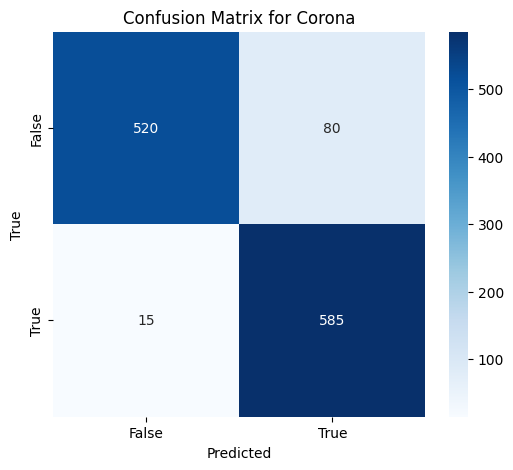

Corona - Precision: 0.8797, Recall: 0.9750, F1-Score: 0.9249


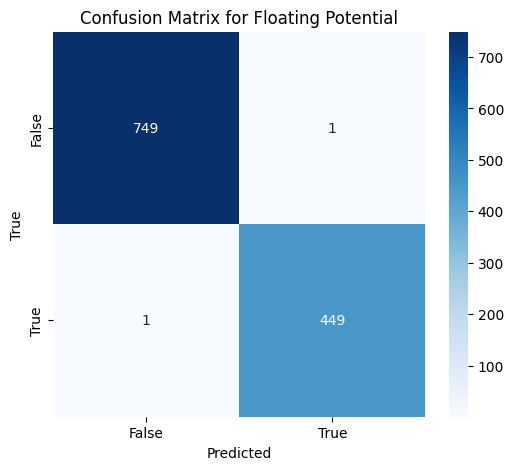

Floating Potential - Precision: 0.9978, Recall: 0.9978, F1-Score: 0.9978


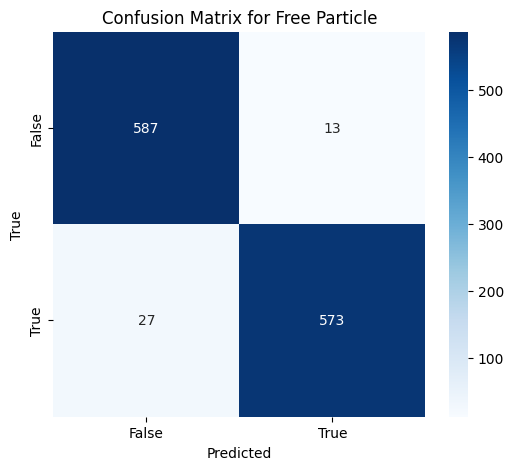

Free Particle - Precision: 0.9778, Recall: 0.9550, F1-Score: 0.9663


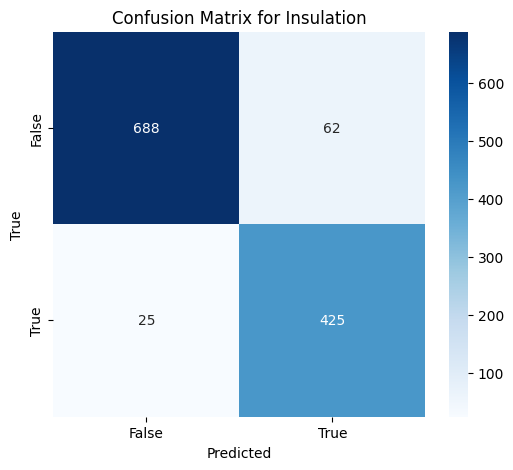

Insulation - Precision: 0.8727, Recall: 0.9444, F1-Score: 0.9072
Macro Precision: 0.9320
Macro Recall: 0.9681
Macro F1-Score: 0.9490
Weighted Precision: 0.9315
Weighted Recall: 0.9676
Weighted F1-Score: 0.9485


In [56]:

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
predicted_labels = (predictions > 0.5).astype(int)  # 对于多标签分类，将预测值二值化
true_labels = test_labels

# 计算样本准确率（Sample-based Accuracy）
sample_accuracy = np.mean(np.all(predicted_labels == true_labels, axis=1))
print(f"Sample-based Accuracy: {sample_accuracy:.4f}")

# 计算整体准确率（Overall Accuracy）
overall_accuracy = np.sum(predicted_labels == true_labels) / np.prod(true_labels.shape)
print(f"Overall Accuracy: {overall_accuracy:.4f}")

# 计算多标签分类的总体精度
true_positives = np.sum(np.logical_and(predicted_labels == 1, true_labels == 1), axis=0)
false_positives = np.sum(np.logical_and(predicted_labels == 1, true_labels == 0), axis=0)

# 总体精度为所有标签的TP之和除以所有标签的TP和FP之和
overall_precision = np.sum(true_positives) / (np.sum(true_positives) + np.sum(false_positives))
print(f"Overall Precision: {overall_precision:.4f}")

# 计算分类报告
report = classification_report(true_labels, predicted_labels, target_names=list(label_mapping.keys()), zero_division=0)
print("Classification Report:\n", report)

# 初始化用于存储每个类别的指标
precisions = []
recalls = []
f1_scores = []

# 计算并显示混淆矩阵
# 由于是多标签分类，需要分别计算每个标签的混淆矩阵
for i, label in enumerate(label_mapping.keys()):
    cm = confusion_matrix(true_labels[:, i], predicted_labels[:, i])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {label}')
    plt.show()
    
    # 计算每个类别的precision, recall, f1-score
    precision = precision_score(true_labels[:, i], predicted_labels[:, i])
    recall = recall_score(true_labels[:, i], predicted_labels[:, i])
    f1 = f1_score(true_labels[:, i], predicted_labels[:, i])
    
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    
    print(f"{label} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# 计算宏平均
macro_precision = np.mean(precisions)
macro_recall = np.mean(recalls)
macro_f1 = np.mean(f1_scores)

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")

# 计算加权平均
weighted_precision = np.average(precisions, weights=np.sum(true_labels, axis=0))
weighted_recall = np.average(recalls, weights=np.sum(true_labels, axis=0))
weighted_f1 = np.average(f1_scores, weights=np.sum(true_labels, axis=0))

print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall: {weighted_recall:.4f}")
print(f"Weighted F1-Score: {weighted_f1:.4f}")

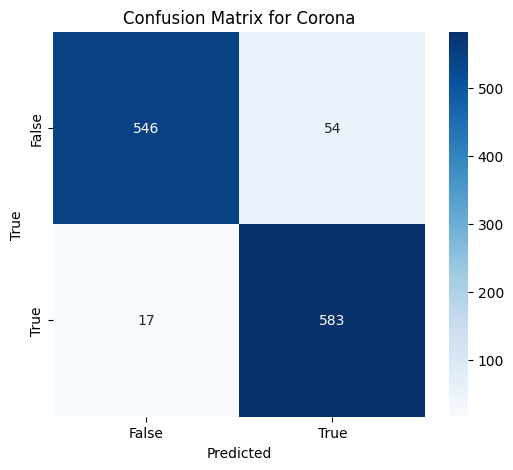

Accuracy for Corona: 0.9408


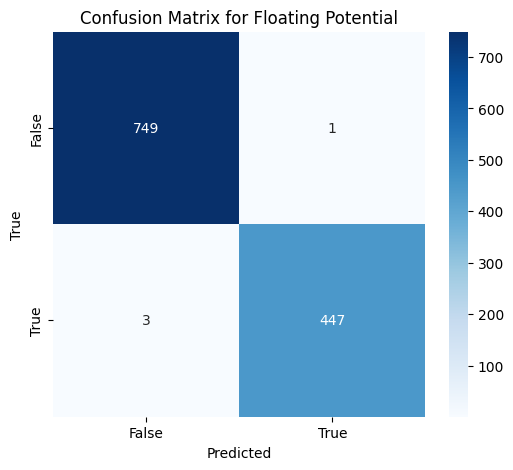

Accuracy for Floating Potential: 0.9967


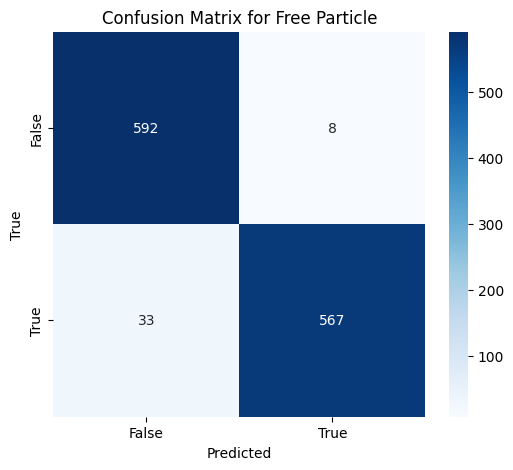

Accuracy for Free Particle: 0.9658


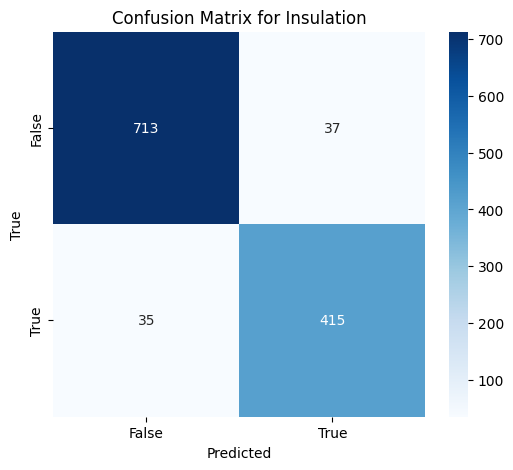

Accuracy for Insulation: 0.9400
Accuracies for each discharge type:
Corona: 0.9408
Floating Potential: 0.9967
Free Particle: 0.9658
Insulation: 0.9400
Overall Accuracy: 0.9608


In [57]:
# 计算分类报告
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
predicted_labels = (predictions > 0.75).astype(int)  # 对于多标签分类，将预测值二值化
true_labels = test_labels

# 初始化一个字典来存储每个局放类型的准确率和混淆矩阵
accuracy_dict = {}

for i, label in enumerate(label_mapping.keys()):
    # 提取特定局放类型的数据
    specific_true_labels = true_labels[:, i]
    specific_predicted_labels = predicted_labels[:, i]

    # 计算特定局放类型的混淆矩阵
    cm = confusion_matrix(specific_true_labels, specific_predicted_labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {label}')
    plt.show()

    # 计算特定局放类型的准确率
    accuracy = accuracy_score(specific_true_labels, specific_predicted_labels)
    accuracy_dict[label] = accuracy
    print(f"Accuracy for {label}: {accuracy:.4f}")

# 输出所有局放类型的准确率
print("Accuracies for each discharge type:")
for label, accuracy in accuracy_dict.items():
    print(f"{label}: {accuracy:.4f}")

# 计算总体准确率
overall_accuracy = accuracy_score(true_labels.flatten(), predicted_labels.flatten())
print(f"Overall Accuracy: {overall_accuracy:.4f}")



In [63]:
# 计算混淆矩阵
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

ValueError: multilabel-indicator is not supported

In [64]:
# 后处理：将未能匹配到任何类别的预测视为噪声
noise_label = np.array([0, 0, 0, 0])



# 计算混淆矩阵
class_names = list(label_mapping.keys())

# 打印每个标签的混淆矩阵
for i, class_name in enumerate(class_names):
    cm = confusion_matrix(val_labels[:, i], val_predictions[:, i])
    print(f"Confusion Matrix for {class_name}:")
    print(cm)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix for {class_name}")
    plt.show()

# 打印分类报告
print("Classification Report:\n", classification_report(val_labels, val_predictions, target_names=label_mapping.keys()))

NameError: name 'val_labels' is not defined